## Modèle ARIMA sur les contrats futures S&P500 (E-minis - ES)

Afin d'élaborer notre stratégie de trading à partir du modèle prédictif (ARIMA/GARCH) nous allons d'abord réaliser une prédiction des E-minis avec le modèle ARIMA.

Pour ce faire nous passerons par 5 étapes :

1. Le sourcing des futures S&P500 (E-minis)
2. La conception des visualisations des simulations
3. La simulation du processus stochastique ARIMA
    * La détermination du critère d'information d'Akaike (AIC)
    * Le tableau des résultats
    * Le data fitting avec le test de Ljung-Box
    * La vérification de la normalité avec le test de Kolmogorov-Smirnov
4. Le diagnostique du modèle et l'estimation de sa précision
5. Le backtesting du modèle et la prédiction


Commençons par importer les librairies utilisées :

In [2]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

### Le sourcing des futures S&P500 (E-minis)

Le sourcing des données porte sur les futures S&P500 (E-minis) du **18 septembre 2000 à aujourd'hui**. 

Pour faire fonctionner notre modèle nous utiliserons :

- **80 % de données d'entrainement (jusqu'au 18 septembre 2016 ~ 4067 données)** 
- **20 % de données de test (du 19 septembre 2016 à aujourd'hui ~ 1017 données)**.

Nous sourçons nos données grâce à notre fournisseur **Yahoo Finance** qui nous permet d'exploiter environ **5084 données**.

In [3]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
startDateStr = '2000/09/18'
endDateStr = '2020/09/18'
cachedFolderName = 'yahooData/'
dataSetId = 'Futures_ES_2000_2020'
instrumentIds = ['ES=F']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                          dataSetId=dataSetId,
                          instrumentIds=instrumentIds,
                          startDateStr=startDateStr,
                          endDateStr=endDateStr,
                          event='history')
data = ds.getBookDataByFeature()['adjClose']
lrets = np.log(data/data.shift(1))

Processing data for stock: ES=F
20% done...
40% done...
60% done...
80% done...


In [3]:
# Selection/Exploration des données sourcées
# Séparation des données d'entrainement et de test

TStraining = lrets['ES=F'].iloc[0:4068].dropna()
TStraining.index = pd.DatetimeIndex(TStraining.index.values, freq=TStraining.index.inferred_freq)

TStest = lrets['ES=F'].iloc[4067:].dropna()
TStest.index = pd.DatetimeIndex(TStest.index.values, freq=TStest.index.inferred_freq)

#### Pourquoi utiliser le logarithme des rendements ?

Commençons par définir un retour : $r_i$ au moment $i$, où $pi$ est le prix au moment $i$ et $j \equiv (i - 1)$ :

$$r_i = \frac {p_i - p_j}{p_j}$$
   

L'avantage de l'utilisation des ***rendements*** , par rapport aux prix, est la ***normalisation*** : mesurer toutes les variables dans une métrique comparable, permettant ainsi l'évaluation des relations analytiques entre deux ou plusieurs variables bien qu'elles proviennent de séries de prix de valeurs inégales. C'est une exigence pour de nombreuses techniques d'analyse statistique multidimensionnelle et d'apprentissage automatique. Par exemple, l'interprétation d'une matrice de covariance d'équité est rendue sensée lorsque les variables sont toutes deux mesurées en pourcentage.

Plusieurs avantages de l'utilisation des ***retours de log***, à la fois théoriques et algorithmiques.

Premièrement, la ***normalité logarithmique*** : si nous supposons que les prix sont distribués log normalement (ce qui, en pratique, peut ou non être vrai pour une série de prix donnée), alors $log(1 + r_i)$ est commodément distribué normalement, car:

$$1 + r_i = \frac{p_i}{p_j} = \exp^{\log(\frac{p_i}{p_j})}$$  

C'est pratique étant donné que la plupart des statistiques classiques présument la normalité.

Deuxièmement, ***l'égalité approximative du log brut*** : lorsque les rendements sont très faibles (courant pour les transactions avec des durées de détention courtes), l'approximation suivante garantit qu'ils sont proches en valeur des rendements bruts:

$$\log(1 + r) \approx r $$avec$$ r \ll 1$$ 

Troisièmement, ***l'additivité au temps*** : considérez une séquence ordonnée de $n$ transactions. Une statistique fréquemment calculée à partir de cette séquence est le ***rendement composé***, qui est le rendement courant de cette séquence de transactions au fil du temps :

$$\displaystyle(1 + r_1)(1 + r_2)\cdots(1 + r_n) = \prod_i(1 + r_i)$$

Cette formule est assez désagréable, car la théorie des probabilités nous le rappelle que le produit de variables normalement distribuées n'est pas normal. Au lieu de cela, la somme des variables normalement distribuées est normale (technicité importante: uniquement lorsque toutes les variables ne sont pas corrélées ), ce qui est utile lorsque l'on rappelle l'identité logarithmique suivante :

$$\log (1 + r_i) = log (\frac {p_i}{p_j}) = \log (p_i) - log (p_j)$$ 

Ainsi, les rendements composés sont normalement distribués. Enfin, cette identité nous conduit à un bénéfice algorithmique agréable; une formule simple pour calculer les rendements composés:

$$\displaystyle \sum_i \log (1 + r_i) = \log (1 + r_1) + \log (1 + r_2) + \cdots + \log (1 + r_n) = \log (p_n) - \log (p_0)$$

Ainsi, le rendement composé sur $n$ périodes est simplement la différence de log entre les périodes initiale et finale. En termes de complexité algorithmique , cette simplification réduit O (n) multiplications à O (1) additions. C'est une énorme victoire pour n modéré à grand. En outre, cette somme est utile pour les cas où les rendements divergent de la normale, car le ***théorème de la limite centrale*** nous rappelle que la moyenne de l'échantillon de cette somme convergera vers la normalité (en supposant des premier et deuxième moments finis).

Quatrièmement, la ***facilité mathématique*** : du calcul, on nous rappelle (en ignorant la constante d'intégration) :

$$e ^ x = \int e ^ x dx = \frac {d}{dx} e ^ x = e ^ x$$ 

Cette identité est extrêmement utile, car une grande partie des mathématiques financières est construite sur des ***processus stochastiques en temps continu*** qui reposent fortement sur l'intégration et la différenciation.

Cinquièmement, la stabilité numérique : l'addition de petits nombres est numériquement sûre, alors que la multiplication de petits nombres ne l'est pas car elle est sujette à un ***dépassement arithmétique***. Pour de nombreux problèmes intéressants, il s'agit d'un problème potentiel sérieux. Pour résoudre ce problème, soit l'algorithme doit être modifié pour être numériquement robuste, soit il peut être transformé en une somme numériquement sûre via des journaux.

### La conception des visualisations des simulations

La fonction ci-dessous nous permet d'afficher 5 graphiques : 

- **La série temporelle**
- **L'ACF**
- **Le PACF**
- **Le diagramme Quantile-Quantile**
- **La courbe de probabilité normale**

Le **PACF** est une **corrélation partielle** entre les résidus, qui tient compte des délais plus courts. L'axe des $x$ indique les valeurs du décalage, $k$ et la région ombrée en bleu indique les **limites de signification**. Seules les valeurs qui se situent en dehors de la région bleue sont **significatives**.

Le **diagramme Quantile-Quantile** compare deux distributions de probabilité en traçant leurs quantiles l'un par rapport à l'autre. Si les deux distributions sont similaires (ou linéairement liées), les points du tracé Q-Q se situeront approximativement sur une ligne. Nous comparons la distribution de nos résidus avec une distribution normale.

La **courbe de probabilité normale** évalue également si un ensemble de données est ou non distribué approximativement normalement. Les données sont tracées par rapport à une distribution normale théorique de telle manière que les points doivent former une ligne droite approximative. Les écarts par rapport à cette ligne droite indiquent des écarts par rapport à la normalité.

In [4]:
def tsplot(y, lags=None, figsize=(12, 8), style='seaborn-darkgrid'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    # Configuration des graphiques
    
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
    # Réalisation des graphiques
    
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

### La simulation du processus stochastique ARIMA (p, d, q)

**ARIMA** est une extension naturelle de la classe des modèles ARMA, les modèles sont utilisés parce qu'ils peuvent **réduire une série non stationnaire à une série stationnaire** en utilisant une séquence de différences.

ARIMA remplit essentiellement la même fonction, mais le fait de manière répétée, $d$ fois, afin de réduire une série non stationnaire à une série stationnaire. Sans trop s'enfoncer dans l'équation, il suffit de savoir qu'une série temporelle $x_t$ est intégrée d'ordre $d$ si nous différons la série $d$ fois et recevons une série discrète de bruit blanc. Une série temporelle $x_t$ est un modèle intégré autorégressif de moyenne mobile d'ordre $p$, $d$, $q$. 

- $p$ est le nombre de termes auto-régressifs
- $d$ est le nombre de différences
- $q$ est le nombre de moyennes mobiles. 

#### La détermination du critère d'information d'Akaike (AIC)

Le critère **AIC** est une **mesure de la qualité d'un modèle statistique**. Il s’applique aux modèles estimés par un **maximum de vraisemblance** : les analyses de variance, les régressions linéaires multiples, les régressions logistiques et de Poisson peuvent rentrer dans ce cadre. Il utilise ce maximum tout en pénalisant les modèles comportant trop de variables, qui **surapprennent** les données et généralisent mal.

Le critère AIC est défini par : $$AIC = −2 log (L) + 2k$$ 

où $L$ est la vraisemblance maximisée et $k$ le nombre de paramètres dans le modèle. 

Avec ce critère, la déviance du modèle $−2 log (L)$ est pénalisée par **2 fois** le nombre de paramètres.

L’AIC représente donc un compromis entre le **biais**, diminuant avec le nombre de paramètres, et la **parcimonie**, volonté de décrire les données avec le plus petit nombre de paramètres possibles. 

- La rigueur voudrait que tous les modèles comparés dérivent tous d’un même « complet » inclus dans la liste des modèles comparés.
- Il est nécessaire de vérifier que les conditions d’utilisation du modèle complet et de celui sélectionné sont remplies.
- Le **meilleur modèle** est celui possédant l’AIC le plus **faible**.



In [1]:
# Choix des meilleur paramètres (ordres) et du modèle final avec l'aic

best_aic = np.inf
best_order = None
best_mdl = None

# [0,1,2,3,4]
pq_rng = range(5)
# [0,1]
d_rng = range(2)

for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                # Simulation du modèle ARIMA
                tmp_mdl = smt.ARIMA(TStraining, 
                                    order=(i, d, j)).fit(method='mle', 
                                                         trend='nc') 
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic: # Choix du meilleur AIC
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.2f} | order: {}'.format(best_aic, best_order))

# Visualisation du modèle ARIMA

_ = tsplot(best_mdl.resid, lags=30)

NameError: name 'np' is not defined

On obtient donc le plus petit **AIC** égale à **-24114.47** et un modèle **ARIMA (3, 0, 3)**. Il n'est pas surprenant que le meilleur modèle ait une différence de 0 puisque nous avons déjà pris la première différence des prix pour calculer les rendements des actions. Le résultat est essentiellement identique au modèle ARMA(3, 3).

#### Le tableau des résultats

In [1]:
# Affichage du tableau des résultats (résumé)
mdl = smt.ARIMA(TStraining, order=(3, 0, 3)).fit(method='mle', trend='nc')
print(mdl.summary())

NameError: name 'smt' is not defined

Nous constatons que le modèle à été capable d'estimer les **coefficients réels**. Nos intervalles de confiance à 95 % contiennent également ces paramètres.

#### Le data fitting avec le test de Ljung-Box

Le test de **Ljung-Box** est un test statistique qui teste **l'auto-corrélation d'ordre supérieur à 1** (dépendance des valeurs résiduelles). Il peut être défini comme :

$H_0$ (hypothèse nulle) : les données sont distribuées **indépendamment** (les corrélations dans la population à partir desquelles l'échantillon est prélevé sont égales à 0, de sorte que toute corrélation observée dans les données résulte du caractère aléatoire du processus d'échantillonnage).

$H_1$ (hypothèse alternative) : les données ne sont pas distribuées indépendamment ; elles présentent une **corrélation** en série.

La statistique du test est:

$$Q = n\left(n+2\right)\sum_{k=1}^h\frac{\hat{\rho}^2_k}{n-k}$$

où $n$ est la taille de l'échantillon, $\hat{\rho}_k$ est l'autocorrélation de l'échantillon au décalage $k$ , et $h$ est le nombre de décalages testés. En dessous de $H_0$ la statistique $Q$ suit asymptotiquement un $\chi_{{(h)}}^{2}$. 

Pour le niveau de signification $\alpha$, la région critique pour le rejet de l'hypothèse du caractère aléatoire est:
$Q > \chi_{1-\alpha,h}^2$ où $\chi_{1-\alpha,h}^2$ est le quantile $1 - \alpha$ de la distribution $\chi_{2}$ avec $h$ degrés de liberté.


Dans notre cas, on retrouve en paramètre notre meilleur modèle : **ARIMA (3,0,3)**. Le test est appliqué aux résidus d'un modèle ARIMA ajusté, et non à la série d'origine, et dans de telles applications, l'hypothèse $H_0$ actuellement testée est que **les résidus du modèle ARIMA n'ont pas d'autocorrélation** (contrairement à l'hypothèse $H_0$ du test Ljung-Box général). 

Lors du test des résidus d'un modèle ARIMA estimé, les degrés de liberté doivent être ajustés pour refléter l'estimation des paramètres. Par exemple, pour un modèle ARIMA (p, 0, q), les degrés de liberté doivent être définis sur $h$ - $p$ - $q$.

De ce test nous sommes censé obtenir la **statistique du test** et la **p-value**.

Si la **p-value** < $0,05$ : Nous **rejetons l'hypothèse nulle** en supposant qu'il y 5% de chances de faire une erreur. Nous supposons que nos valeurs montrent une **dépendance** les unes envers les autres.

Si la **p-value** > $0,05$ : Nous n'avons pas suffisamment de preuves statistiques pour rejeter l'hypothèse nulle. Nous ne pouvons donc pas supposer que nos valeurs sont dépendantes. Cela peut signifier que nos valeurs sont **indépendantes** ou qu'elles **dépendent de toute façon**. En effet, nous ne pouvons pas prouver de possibilités spécifiques, c'est à dire que nous ne pouvons pas affirmer la dépendance des valeurs, ni affirmer l'indépendance des valeurs (non confirmation de l'hypothèse nulle).


Comme expliqué au début, nous ne pouvons pas prouver l'indépendance des valeurs des séries temporelles à l'aide du test Ljung-Box mais **seulement** la dépendance.

In [7]:
# Data fitting avec Ljung-Box
# Décalage 20

sms.diagnostic.acorr_ljungbox(best_mdl.resid, 
                              lags=[20], 
                              boxpierce=False, 
                              return_df=True)

,lb_stat,lb_pvalue
20,25.458534,0.184448


Ainsi nous retrouvons la statistique du test de Ljung-Box égale à $25$ et la p-value égale à $0.19$. Cette dernière est supérieur à $0,05$, nous ne pouvons donc pas rejeter l'hypothèse nulle ni conclure si nos valeurs sont corrélées ou non.

En revanche ce que nous pouvons faire pour prouver l'autocorrélation des résidus c'est de tout simplement regarder **l'autocorrélation des carrés des résidus**.

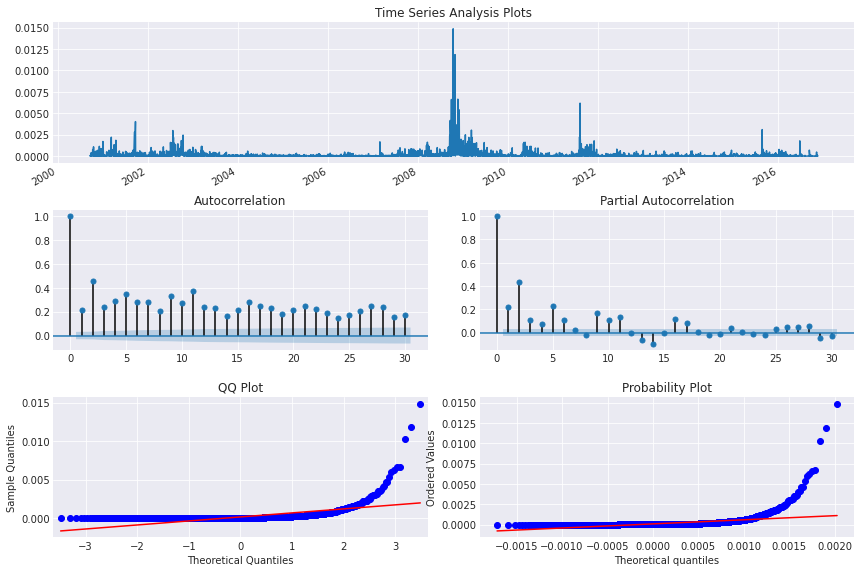

In [8]:
# Affichage du carré des résidus

tsplot(best_mdl.resid**2, lags=30)

Ainsi, nous pouvons voir des preuves claires d'**autocorrélation dans les résidus au carré**.

#### La vérification de la normalité avec le test de Kolmogorov-Smirnov

En statistiques, le test de **Kolmogorov-Smirnov** est un test d'hypothèse utilisé pour déterminer si un échantillon suit bien une loi donnée connue par sa **fonction de répartition continue**, ou bien si deux échantillons suivent la même loi. Nous allons vérifier grâce à ce test si notre modèle est **normalement** distribué.


L'hypothèse nulle est : $H_0$: la loi $P$ a pour fonction de répartition $F_0$


où $F_0$ est la fonction de répartition d'une loi continue donnée.


L'idée est la suivante : si l'hypothèse $H_0$ est correcte, alors la fonction de répartition empirique $\widehat{F}$ de l'échantillon doit être proche de $F_0$.


La fonction de repartition empirique est la fonction de $\mathbb{R}$ dans [0,1], qui vaut :
$$
\widehat{F}(x) =
\begin{cases}
0 \; pour \; x < X_{(1)} \\
\text{...} \\
\frac{i}{n} \;
pour \; X_{(i)}\leq x < X_{(i+1)}\\
\text{ ... }\\
1 \; pour \; x \ge X_{(n)}
\end{cases}
$$


où les $ X_{(i)}$ sont les statistiques d'ordre de l'échantillon (valeurs de l'échantillon rangées par ordre croissant). En d'autres termes, $ \widehat{F}(x)$ est la proportion d'éléments de l'échantillon qui sont inférieurs ou égaux à $ x$.


On mesure l'adéquation de la fonction de répartition empirique à la fonction $ F_0$ par la distance de Kolmogorov-Smirnov, qui est la distance de la norme uniforme entre fonctions de répartitions. Pour la calculer, il suffit d'évaluer la différence entre $ \widehat{F}$ et $ F_0$ aux points $ X_{(i)}$.


$$ D_{KS}(F_0,\widehat{F}) = \max_{i=1,\ldots,n}\left\{\; \middle| F_0 (X_{(i)}) - \frac{i}{n}\middle| \; , \;  \middle| F_0 (X_{(i)}) -\frac{i-1}{n}\middle| \; \right\}.
$$

In [9]:
# Test de normalité

from statsmodels.stats.diagnostic import kstest_normal

score, pvalue = kstest_normal(mdl.resid)

if pvalue < 0.10:
    print('La p-value est de {}. Le résidu ne semble pas normalement distribué.'.format(pvalue))
else:
    print('La p-value est de {}. Le résidu semble être distribué normalement.'.format(pvalue))

La p-value est de 7.450330120387874e-94. Le résidu ne semble pas normalement distribué.


Ainsi, le test Kolmogorov-Smirnov semble montrer que le résidu n'est pas normalement distribué.

###  Le diagnostique du modèle

Le diagnostique du modèle nous permet de comparer les valeurs prédites aux valeurs réelles de la série chronologique, ce qui nous aidera à comprendre l'**exactitude de nos prévisions** et le **pouvoir prédictif** du modèle.

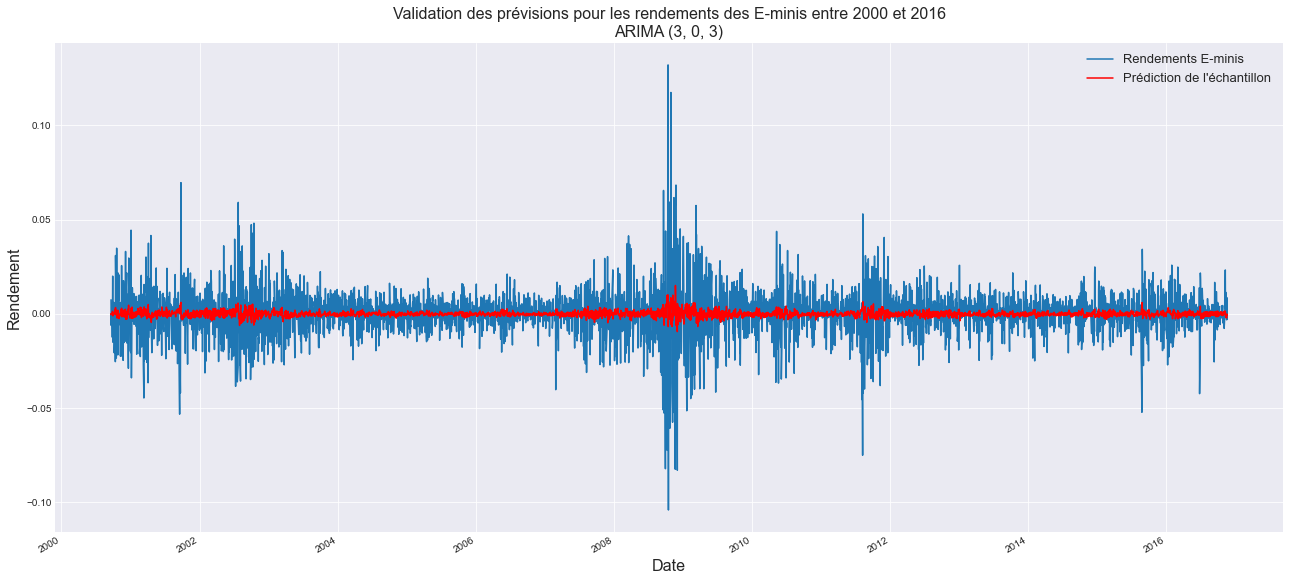

In [10]:
# Configuration du graphique

plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(22,10))
ax = plt.gca()
graph = TStraining.plot(ax=ax, label='Rendements E-minis')
graph.set_xlabel('Date', fontsize=16)
graph.set_ylabel('Rendement', fontsize=16)

# Prévision de l'échantillon

pred = best_mdl.predict(TStraining.index[0], TStraining.index[-1])
pred.plot(ax=ax, style='r-', label='Prédiction de l\'échantillon')

plt.title('Validation des prévisions pour les rendements des E-minis entre 2000 et 2016\nARIMA {}'.format(best_order), fontsize=16)
plt.legend(loc='best', fontsize=13)

Il semblerait que nos prévisions soient sensiblements les mêmes que la série temporelle originelle.

### L'estimation de sa précision

Il est utile de quantifier l'exactitude de nos prévisions. Nous utilisons l'**erreur quadratique moyenne**, qui résume l'erreur moyenne de nos prévisions. Pour chaque valeur prédite, nous calculons sa **distance** par rapport à la vraie valeur et la quadrature du résultat. Les résultats doivent être mis au **carré** afin que les différences positives / négatives ne s'annulent pas lorsque nous calculons la moyenne globale. Plus l'erreur quadratique moyenne est proche de **0** plus notre modèle est **précis**.

In [11]:
# Calcule de l'erreur quadratique moyenne

mse = ((pred - TStraining) ** 2).mean()
print('L\'erreur quadratique moyenne de la prévision est {}'.format(round(mse, 6)))

L'erreur quadratique moyenne de la prévision est 0.000155


###  Le backtesting du modèle et la prédiction

In [2]:
# Création d'une prévision sur 365 jours des rendements ES avec une intervalle de confiance à 95% et 99%.

n_steps = 365

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # Intervalle de confiance à 95%
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # Intervalle de confiance à 99%

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['Prédiction', 'lower_95', 'upper_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_99', 'upper_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

NameError: name 'best_mdl' is not defined

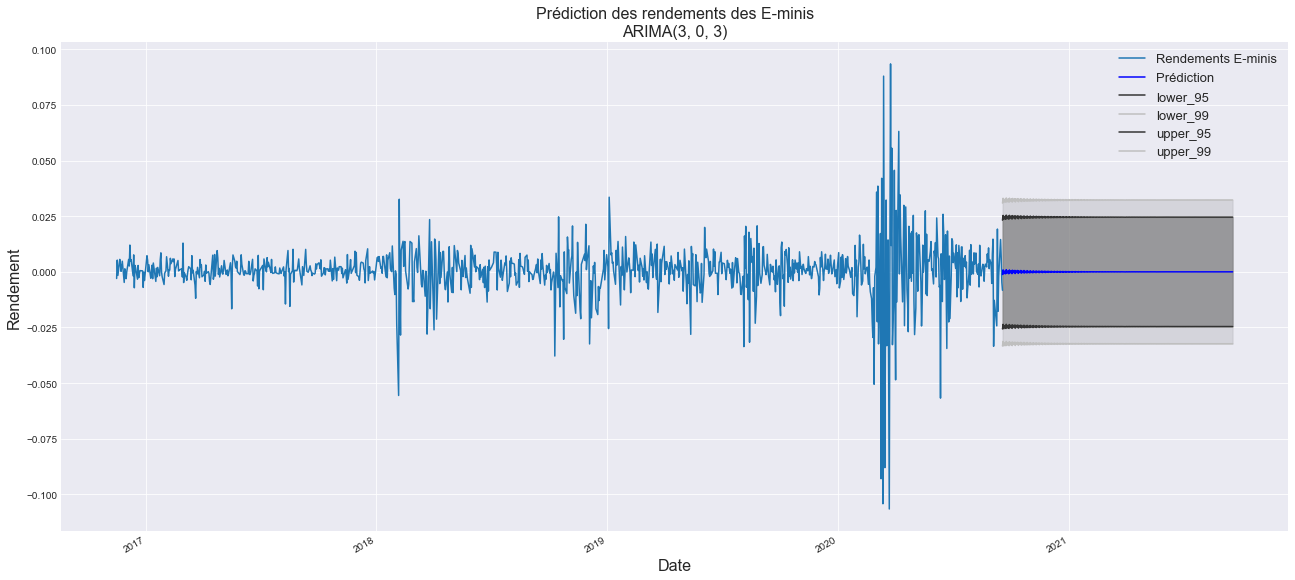

In [13]:
# Configuration du graphique

plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(22,10))
ax = plt.gca()
graph = TStest.plot(ax=ax, label='Rendements E-minis')
graph.set_xlabel('Date', fontsize=16)
graph.set_ylabel('Rendement', fontsize=16)

# Prédiction de l'échantillon

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)

plt.fill_between(fc_all.index, fc_all.lower_95, fc_all.upper_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_99, fc_all.upper_99, color='gray', alpha=0.2)

plt.title('Prédiction des rendements des E-minis\nARIMA{}'.format(best_order), fontsize=16)
plt.legend(loc='best', fontsize=13)